In [171]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from time import time 
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score


In [172]:
import multiprocessing as mp
n_cpu=mp.cpu_count()
print(n_cpu)

10


## Data preprocessing

In [173]:
# dataset = pd.read_csv("Data_Files 2023/epl-training.csv")
dataset = pd.read_csv("Data_Files 2023/new_epl_training.csv")

### Format Correction

In [174]:
# Correct date format and remove empty value
dataset['Date'] = pd.to_datetime(dataset.Date, dayfirst=True).dt.normalize()
dataset.dropna(subset=['Date'], inplace = True)

/var/folders/_g/11z6h9c564bd848z1gqfm_qc0000gn/T/ipykernel_27717/2374665266.py:2: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  dataset['Date'] = pd.to_datetime(dataset.Date, dayfirst=True).dt.normalize()


### Standardize data

In [175]:
# Turn H, A, D into numeracal value for heatmap
from sklearn.discriminant_analysis import StandardScaler


# replacements = {'H': 1, 'A': -1, 'D': 0}
# dataset['HTR'] = dataset['HTR'].map(replacements).fillna(dataset['HTR'])
# dataset['FTR'] = dataset['FTR'].map(replacements).fillna(dataset['FTR'])

# removes the categorial data & FTR & HTR
cols = ['FTHG','FTAG', 'HTHG','HTAG','HS','AS','HST','AST','HC','AC','HF','AF','HY','AY','HR','AR','temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 
        'rain_sum (mm)', 'snowfall_sum (cm)','wind_speed_10m_max (km/h)','Home_GK_Ability','Away_GK_Ability','Home_team_offensive_ability', 'Away_team_offensive_ability',
        'Home_team_possession_ability','Away_team_possession_ability', 'Home_team_defensive_ability','Away_team_defensive_ability','Fouls_Difference','Yellows_Difference',
        'Reds_Difference', 'Referee_Bias_Index','HomeTeam_Elo_Before_Match','AwayTeam_Elo_Before_Match','HomeTeam_Offensive_Shooting_Efficiency',
        'AwayTeam_Offensive_Shooting_Efficiency','HomeTeam_Offensive_Shots_on_Target_Efficiency','AwayTeam_Offensive_Shots_on_Target_Efficiency',
        'HomeTeam_Season_Offensive_Shooting_Efficiency','AwayTeam_Season_Offensive_Shooting_Efficiency','HomeTeam_Season_Offensive_Shots_on_Target_Efficiency',
        'AwayTeam_Season_Offensive_Shots_on_Target_Efficiency','HomeTeam_Season_Defensive_Shooting_Efficiency','AwayTeam_Season_Defensive_Shooting_Efficiency',
        'HomeTeam_Season_Defensive_Shots_on_Target_Efficiency','AwayTeam_Season_Defensive_Shots_on_Target_Efficiency','HomeTeam_HomeWinRate','AwayTeam_AwayWinRate',
        'HomeTeam_HomeGoalsRatio','AwayTeam_AwayGoalsRatio','HomeTeam_HomeWinsRatio','AwayTeam_AwayWinsRatio','EPL','HomeTeam_CupGamesLastMonth',
        'AwayTeam_CupGamesLastMonth','HomeTeam_Morale','AwayTeam_Morale','Curse_Parameter'
        ]
""" 
cols = ['FTHG','HTHG','HS','HST','HC','HF','HY','HR',
        'Home_GK_Ability',
        'Home_team_offensive_ability','Home_team_possession_ability',
        'Home_team_defensive_ability','Fouls_Difference','Yellows_Difference','Reds_Difference',
        'Referee_Bias_Index','HomeTeam_Elo_Before_Match','HomeTeam_Offensive_Shooting_Efficiency',
        'HomeTeam_Offensive_Shots_on_Target_Efficiency',
        'HomeTeam_Season_Offensive_Shooting_Efficiency','HomeTeam_Season_Offensive_Shots_on_Target_Efficiency',
        'HomeTeam_Season_Defensive_Shooting_Efficiency',
        'HomeTeam_Season_Defensive_Shots_on_Target_Efficiency','HomeTeam_HomeWinRate',
        'HomeTeam_HomeGoalsRatio','HomeTeam_HomeWinsRatio','EPL','HomeTeam_CupGamesLastMonth',
        'HomeTeam_Morale','Curse_Parameter'
        ]
"""


scaler = StandardScaler()  
dataset[cols] = scaler.fit_transform(dataset[cols])

# dataset.to_excel("hihi.xlsx")

In [176]:
# try standardization and normalization to see which one works better for our specific dataset and model

### Visualize data

In [177]:
# Scatter matrix
# scatter_matrix(dataset[cols], figsize=(20,20))

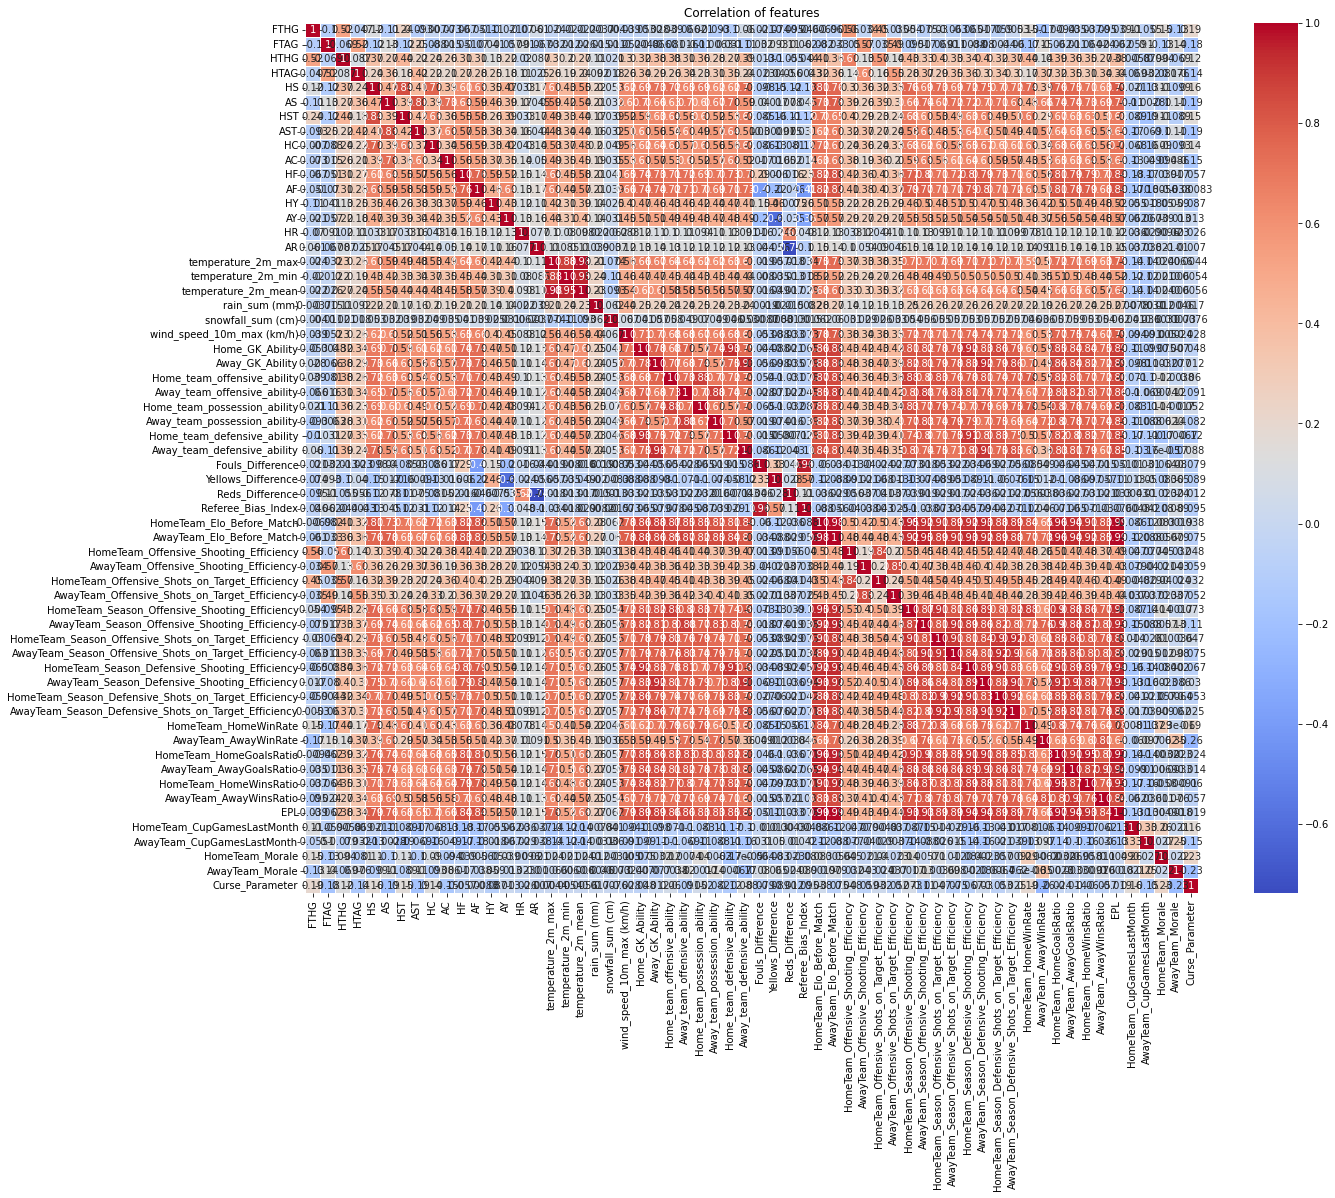

In [178]:
# Heat Map
correlation_matrix = dataset[cols].corr()

# Create a heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=1.0)

# Display the plot
plt.title('Correlation of features')
plt.show()


### Preprocess catagorical data

In [179]:
from sklearn.impute import SimpleImputer


def preprocess_features(X):
    ''' Converts catagorical variables into dummy variables. '''
    
    output = pd.DataFrame(index = X.index)

    for col, col_data in X.items():

        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col, dtype=int)
                    
        output = output.join(col_data)
    
    return output


# print(sum(dataset["FTR"]=="H"))
# print(sum(dataset["FTR"]=="A"))
# print(sum(dataset["FTR"]=="D"))

# separate data and outcome from dataset to preprocess features & remove correlated data
y = dataset['FTR']
# corr_data = ['FTHG','FTAG','FTR','HTHG','HTAG','HTR','HS','AS','HST','AST','HY','AY','AC','AF']
X = dataset.drop(['FTR','FTHG','FTAG'],axis=1)

# month & day cyclic
X['Date_Year'] = X['Date'].dt.year
X['Date_Month'] = X['Date'].dt.month
X['Date_Day'] = X['Date'].dt.day
X = X.drop(['Date'], axis=1)

X = preprocess_features(X)

# Shuffle and split the dataset into training, validation and testing set.
# 60% Training data, 20% Validation, 20% Testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.20, shuffle=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, shuffle=True)


# X_train = preprocess_features(X_train)
# X_val = preprocess_features(X_val)
# X_test = preprocess_features(X_test)
# X.to_excel("output.xlsx") 


# # Preprocess test set feature with 
# test_feature = ['HomeTeam', 'AwayTeam', 'Date']
# for i in X_test.columns:
#     feature_prefix = i.split('_', 1)[0]
#     if feature_prefix not in test_feature:
#         X_test[i] = 0

# imputer = SimpleImputer(strategy='mean')
# imputer.set_params(keep_empty_features=True)
# imputer.fit_transform(X)
# print(X_test.head())
# train_feature_prefix = set(col.split('_', 1)[0] for col in X_train.columns)

# Example: Modifying X_test based on feature prefixes using pd.concat()
# modified_columns = {col: None for col in X_test.columns if col.split('_', 1)[0] not in test_feature_prefix}
# X_test_modified = pd.concat([X_test, pd.DataFrame(modified_columns, index=X_test.index)], axis=1)
# X_test.to_excel("hihi.xlsx")

# X_test = X_test[['HomeTeam', 'AwayTeam','Date_Year','Date_Month','Date_Day']]


from imblearn.over_sampling import SMOTE, RandomOverSampler
# re-sampleing data using SMOTE:
# smote = SMOTE(random_state=42)
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_val, y_train_val)

# print(sum(y_train_resampled=="H"))
# print(sum(y_train_resampled=="A"))
# print(sum(y_train_resampled=="D"))



In [180]:
from sklearn.metrics import ConfusionMatrixDisplay

def draw_cm(model, y_true, y_pred, dataset_type):
    
    class_label = model.classes_
    
    cm = confusion_matrix(y_true, y_pred, labels=class_label)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_label, yticklabels=class_label)

    plt.xlabel("Predicted result")
    plt.ylabel("Actual result")
    plt.title(model.__class__.__name__ + " confusion matrix for " + dataset_type)

    plt.show()
    
def predict(model, features, target, dataset_type):
    ''' Makes predictions using a model and return its accuracy. '''

    start = time()
    y_pred = model.predict(features)
    end = time()

    print("Made predictions in {:.4f} seconds.".format(end - start))

    draw_cm(model, target, y_pred, dataset_type)

    return accuracy_score(target, y_pred, normalize=True) * 100


def train_predict(model, X_train, y_train, X_val, y_val, X_test, y_test):
    ''' Train model and show accuracy of predicting the result.'''

    print("Training model: {}".format(model.__class__.__name__))
    print("Training size: {}".format(len(X_train)))
    print("Testing size: {}".format(len(X_test)))
    
    # Train model
    start = time()
    model.fit(X_train, y_train)
    end = time()
    print("Trained model in {:.4f} seconds".format(end - start))

    # Train accuracy
    train_accuracy = predict(model, X_train, y_train, "training set")
    print("Accuracy for training set:  {:.2f}%.".format(train_accuracy))

    # Validation 
    val_accuracy = predict(model, X_val, y_val, "validation set")
    print("Validation accuracy:  {:.2f}%.".format(val_accuracy))

    # # Test
    # # preprocess test data
    # test_accuracy = predict(model, X_test, y_test, "test set")
    # print("Test accuracy:  {:.2f}%.".format(test_accuracy))

In [181]:

import numpy as np
from sklearn.calibration import cross_val_predict
from sklearn.model_selection import StratifiedKFold


LR_model = LogisticRegression(C=1, solver='lbfgs', max_iter=4000)
# train_predict(LR_model, X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test)
# print ('')

# cross validation 
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation with stratified sampling
cv_scores = cross_val_score(LR_model, X_train_resampled, y_train_resampled, cv=stratified_kfold, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)

from sklearn.model_selection import RandomizedSearchCV
# Hyperparameter space
param_distributions = {'penalty' : ['l1','l2', 'elasticnet'],                 
                 'C' : np.logspace(-1,1,10),                                
                 'solver' : ['saga', 'lbfgs'],                               
                 }
# param_distributions = {'solver': ['liblinear','lbfgs','newton-cg','sag','saga'],
#                        'C': np.logspace(-2, 2, 5), 
#                        'penalty': ['l1', 'l2', 'elasticnet'],
#                         'l1_ratio': [0.2, 0.4, 0.6, 0.8]}
# Randomized search with 3-fold cross-validation
search = RandomizedSearchCV(LogisticRegression(), param_distributions, 
                            n_iter=1000, scoring='accuracy', cv=5, random_state=42)
 
search.fit(X_train_resampled, y_train_resampled)
best_params = search.best_params_
best_model = search.best_estimator_
print(search.best_estimator_)
test_accuracy = best_model.score(X_test, y_test)
print(test_accuracy)



 
# # Fit to data
# search.fit(X_train_val, y_train_val)
# model = search.best_estimator_
# y_pred = model.predict(X_test)
# classification_report(y_test, y_pred)
# draw_cm(model, y_test, y_pred, "rancv")

# y_pred = cross_val_predict(LR_model, X_test, y_test, cv=5)
# # LR_model.predict(X_test)
# draw_cm(LR_model, y_test, y_pred, "using cv")
# print(accuracy_score(y_test, y_pred, normalize=True) * 100)
# print("Mean Accuracy:", cv_scores.mean())


# # Train and predict the data using different model
# lg_solver = ['liblinear','lbfgs','newton-cg','sag','saga']
# for solver in lg_solver:

#     scores = {}
#     for C in (10**k for k in range(-2, 3)):
#         lr = LogisticRegression(C=C, solver=solver, max_iter=4000)
#         lr.fit(X_train, y_train)
#         scores[C] = {'train accuracy': lr.score(X_train, y_train), 
#                     'test accuracy': lr.score(X_test, y_test)}

#     # plot the accuracy scores for different values of C
#     df = pd.DataFrame.from_dict(scores, 'index')
#     df.plot(title=solver, logx=True, xlabel='C', ylabel='accuracy')

    
# Create Logistic Regression model with regularization
# LR_model = LogisticRegression(C=0.1, solver='sag', max_iter=1000)
# LR_model = LogisticRegression(C=0.1, solver='liblinear', max_iter=1000)
# LR_model = LogisticRegression(C=0.1, solver='lbfgs', max_iter=1000)


# svm_model = SVC(random_state = 912)
# train_predict(svm_model, X_train_resampled, y_train_resampled, X_val, y_val, X_test, y_test)
# print ('')

/Users/zhumozhao/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/zhumozhao/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Cross-Validation Scores: [0.8984556  0.9003861  0.88687259 0.89300888 0.89571263]


/Users/zhumozhao/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhumozhao/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhumozhao/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhumozhao/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zhumozhao/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

LogisticRegression(C=2.1544346900318834)
0.8095838587641866


/Users/zhumozhao/.pyenv/versions/3.9.1/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
